# Establish Baseline and Evaluation Metric & Build and Interpret Models

**Introduction & Goal:**

This project aims to build a *rating predictor* for a big online wine seller. Provided dataset is a sample of whole inventory of the client (possibly [winemag](https://www.winemag.com/)) and aims to show good prediction is possible and thereby make it less risky to implement a full production solution.

As part of this project a complete machine learning pipeline will be built. Then the built model will be automated using Docker & Luigi and finally model will be evaluated with the test dataset. This document presents a summary of the whole pipeline.

**Remarks:**
* The dataset is a sample dataset, meaning test dataset may have first-time-seen values.
* Test dataset is expected to have 100k rows, brings attention to the performance when selecting model.

**Report structure:**

1. Understand & Clean & Format Data
2. Exploratory Data Analysis
3. Feature Engineering and Selection
4. Set Metric & Establish Evaluation Baseline & Build Machine Learning Models
5. Tune the Parameters of the Model
6. Evaluate Model on Test Data
7. Interpret Model Predictions
8. Conclusions

This document will cover the last half of the workflow: Sections 4, 5, 6 and 7.

In Section 4, we are going to set our metric, establish a baseline, build a model and train the model on the training datasets(X_train and y_train). *Training a model* means letting a model to catch the patterns in the training dataset and match those patterns to target variable, in our case points.

In Section 5, we are going to determine the ideal parameters comprising a model by fine-tuning the model hyperparameters with cross-validation. *Cross-Validation* is a mechanism for estimating how well a model will generalize to new data by testing the model against one or more non-overlapping data subsets withheld from the training set.

In Section 6, we are going to feed the test data -the data that our model never seen before- into our model and monitor our evaluation metric.

In section 7,we are going to look at the model results on test data, since we have also separated out the actual values of our target value as test_target. Finally, in section 8 we will draw our conclusions.

**Imports**

In [30]:
# visualization and manipulation libraries
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 60)

%matplotlib inline
# to display visuals in the notebook

%config InlineBackend.figure_format='retina'
#to enable high resolution plots

# feature prepocessing and split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, SCORERS, f1_score

# Machine Learning Models
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# to visualize a decision tree
import sklearn.tree as tree
import pydotplus
from sklearn.externals.six import StringIO
from IPython.display import Image

In [24]:
SCORERS

{'explained_variance': make_scorer(explained_variance_score),
 'r2': make_scorer(r2_score),
 'max_error': make_scorer(max_error, greater_is_better=False),
 'neg_median_absolute_error': make_scorer(median_absolute_error, greater_is_better=False),
 'neg_mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False),
 'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False),
 'neg_mean_squared_log_error': make_scorer(mean_squared_log_error, greater_is_better=False),
 'neg_root_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False, squared=False),
 'neg_mean_poisson_deviance': make_scorer(mean_poisson_deviance, greater_is_better=False),
 'neg_mean_gamma_deviance': make_scorer(mean_gamma_deviance, greater_is_better=False),
 'accuracy': make_scorer(accuracy_score),
 'roc_auc': make_scorer(roc_auc_score, needs_threshold=True),
 'roc_auc_ovr': make_scorer(roc_auc_score, needs_proba=True, multi_class=ovr),
 'roc_auc_ovo': make_sc

**Functions to use in Part 4**

In [25]:
def fit_evaluate_model(model, X_train, y_train, X_valid, y_valid):
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_valid)
    return f1_score(y_valid, y_predicted, average='weighted')

def convert_features_to_array(features):
    num_rows = len(features)
    num_cols = len(features.columns)
    
    features_array = (np
                      .array(features)
                      .reshape((num_rows, 
                                num_cols)))

    return features_array

def convert_target_to_array(target):
    target_array = np.array(target).reshape((-1, ))
    return target_array

# Recap from the Previous Document

In the first notebook, we focused on understanding, formatting and cleaning data. Then we visualized features and decided which features to include in our model. Moreover, we have added some new features from the existing ones. Finally we created output files of training, validation and test sets that are ready to be inputted into machine learning models.

**Load data into dataframes**

In [3]:
X_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv")

X_valid = pd.read_csv("X_valid.csv")
y_valid = pd.read_csv("y_valid.csv")

test_features = pd.read_csv("test_features.csv")
test_target = pd.read_csv("test_target.csv")

98–100 – Classic
94–97 – Superb
90–93 – Excellent
87–89 – Very good
83–86 – Good
80–82 – Acceptable

In [9]:
def convert_points_to_class(series):
    # acceptable wines
    if series <= 82:
        return 1

    # good wines
    elif series <= 86:
        return 2

    # very good wines
    elif series <= 89:
        return 3

    # excellent wines
    elif series <= 93:
        return 4

    # superb wines
    elif series <= 97:
        return 5

    # classic wines
    elif series <= 100:
        return 6

def add_points_class(df):
    df["points_class"] = df["points"].apply(convert_points_to_class)

In [10]:
add_points_class(y_train)

In [15]:
y_train.points_class.value_counts()

3    2349
4    2226
2    1680
5     308
1     141
6       7
Name: points_class, dtype: int64

In [17]:
add_points_class(y_valid)
y_valid.points_class.value_counts()

3    797
4    758
2    536
5     94
1     48
6      4
Name: points_class, dtype: int64

In [18]:
add_points_class(test_target)
test_target.points_class.value_counts()

3    363
4    329
2    230
5     54
1     24
Name: points_class, dtype: int64

In [28]:
y_train.drop(columns="points", inplace = True)
y_valid.drop(columns="points", inplace = True)
test_target.drop(columns="points", inplace = True)

# Set Metric & Establish Evaluation Baseline & Build Machine Learning Models

## Set Metric & Establish Evaluation Baseline

Since our problem is a regression (e.g. we are trying to predict a continuous variable), the mean square error (MSE) is an appropriate metric and with the optimization criteria of our selected ML model. 

Mean squared error is the average of the squared differences of actual values and predictions.

This is also an interpretable metric, because it is analogous of variance. In other words, we are going to evaluate 
our model by looking at the measure of how large our squared errors (residuals) are spread out.

Before building the models we are going to construct a common-sense baseline with MSE. A common-sense baseline can be explained as generating a naive guess about the predictions by using some expert knowledge or few lines of code.

If our models cannot beat this baseline, then machine learning may not be the best approach to solve this problem or whole preprocessing steps needs re-consideration. For our regression problem, a simple common-sense baseline is to predict the variance of the mean of the training set to the validation set. This approach aligns with our evaluation metric MSE as well.

Looking at the value counts above most common class is class 3 very good wines. If our model has predicted everyting as a very good wine it would get correct results with probability 35 percent which would yield an f1 socre of 2r/r+1 resulting in 0.52.

In [19]:
print(2349/len(y_train))

0.3500223513634332


In [20]:
print("f1 score is:", (2*(0.35))/(0.35+1))

f1 score is: 0.5185185185185185


baseline = (np
            .mean(
                convert_target_to_array(y_train)))

mse_baseline = (np
                .mean(
                    np.square(
                        baseline - convert_target_to_array(y_valid))))

print("Baseline mse is:", round(mse_baseline, 2))

This shows our average variance estimate on the validation set is off by about 9.01 points. If our model can lower this variance, we can be confident that our problem is a-ML-applicable problem and our model is a reasonable solution for that.

## Build Machine Learning Models

Several models are tried out in a another notebook and random forests from scikit-learn library is decided considering, model explainability, reasonable run-times and evaluation metric.

Random forests is an ensemble model built on multiple decision trees. To understand how model works, first we should understand how a decision tree works.

A decision tree builds tree structure and uses this tree structure to make predictions. It breaks down a dataset into smaller and smaller subsets while at the same time an associated decision tree is incrementally developed. The final result is a tree with decision nodes and leaf nodes. A decision node has two or more branches, each representing values for the attribute tested. Leaf node represents a decision on the numerical target.

Random forests is an algorithm that builds multiple decision trees once and trains them on various sub-samples of the dataset. Final predictions are generated by averaging the results of all decision trees.

There is a possibility of decreasing our MSE further by tuning the parameters of the random forests model. Remember that MSE represents the average error between the actual and predicted values, thus lower the MSE better the model is. Now let's look at that possibility.

%%time
random_forests = RandomForestRegressor(random_state=42)
mse_rf = fit_evaluate_model(random_forests, 
                            X_train, 
                            convert_target_to_array(y_train), 
                            X_valid, 
                            convert_target_to_array(y_valid))

print("MSE of Random Forests", mse_rf)

MSE has significantly decreased from 9.01 to 5.48 resulting in 39% improvement. This shows that our problem and features can be approached and solved by a machine learning model.

In [31]:
%%time
rf_clf = RandomForestClassifier(random_state=42)
f1_rf = fit_evaluate_model(rf_clf,
                           X_train,
                           convert_target_to_array(y_train),
                           X_valid,
                           convert_target_to_array(y_valid))

print("F1 score of Random Forests Classifier", f1_rf)

F1 score of Random Forests Classifier 0.4821847488314463
CPU times: user 706 ms, sys: 23.4 ms, total: 730 ms
Wall time: 729 ms


# Tune the Parameters of the Model

In [32]:
# The number of trees in the forest algorithm, default value is 100.
n_estimators = [100, 200, 300, 500, 1000]

# The minimum number of samples required to split a decision node, default value is 2.
min_samples_split = [2, 4, 6, 10]

# The minimum number of samples required to be at a leaf node, default value is 1.
min_samples_leaf = [1, 2, 4, 6, 8]

# The number of features to consider when looking for the best split, default value is auto.
max_features = ['auto', 'sqrt', 'log2', None]

# Define the grid of hyperparameters to search
hyperparameter_grid = {"n_estimators": n_estimators,
                       "min_samples_split": min_samples_split,
                       "min_samples_leaf": min_samples_leaf,
                       "max_features": max_features
                       }

In [34]:
# add dataframes back for to use them in random search
X = pd.concat([X_train, X_valid])
y = pd.concat([y_train, y_valid])

# create Randomized search object
rf_clf_random_cv = RandomizedSearchCV(estimator=rf_clf,
                                      param_distributions=hyperparameter_grid,
                                      cv=4, n_iter=25,
                                      scoring='f1_weighted',
                                      n_jobs=-1, verbose=1,
                                      return_train_score=True,
                                      random_state=42)

rf_clf_random_cv.fit(convert_features_to_array(X),
                     convert_target_to_array(y))

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished


RandomizedSearchCV(cv=4, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [35]:
rf_clf_random_cv.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

## Revisit MSE after tuning the parameters

In [38]:
%%time
rf_clf_optimal = rf_clf_random_cv.best_estimator_
f1_rf_opt = fit_evaluate_model(rf_clf_optimal,
                               X_train,
                               convert_target_to_array(y_train),
                               X_valid,
                               convert_target_to_array(y_valid))

print("MSE of fine-tuned random forests", f1_rf_opt)

MSE of fine-tuned random forests 0.4964393362172173
CPU times: user 1.17 s, sys: 30 ms, total: 1.2 s
Wall time: 1.2 s


Our metric, MSE decreased from 5.48 to 5.01 showing 0.4 points decrease after the fine-tune. Overall, we showed an improvement of 45% improvement compared to our common-sense baseline. Now let's train our model with the fine-tuned random forests model and evaluate it with the test set.

# Evaluate Model on Test Data

In [39]:
%%time
# fit on the initial model
rf_clf.fit(X,
           convert_target_to_array(y))

CPU times: user 877 ms, sys: 33.1 ms, total: 910 ms
Wall time: 912 ms


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [40]:
%%time
# fit on the optimal(tuned) model
rf_clf_optimal.fit(X,
                   convert_target_to_array(y))

CPU times: user 1.43 s, sys: 36.9 ms, total: 1.46 s
Wall time: 1.47 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [42]:
# initial model's mse on test set
initial_predictions = rf_clf.predict(test_features)
initial_f1 = f1_score(test_target,
                         initial_predictions, average="weighted")

print("Initial model performance on the test set: f1 = {}".
      format(round(initial_f1, 2)))

Initial model performance on the test set: f1 = 0.49


In [43]:
# optimal(tuned) model's mse on test set
tuned_predictions = rf_clf_optimal.predict(test_features)
tuned_f1 = f1_score(test_target,
                    tuned_predictions, average="weighted")

print("Optimal model performance on the test set: f1 = {}".
      format(round(tuned_f1, 2)))

Optimal model performance on the test set: f1 = 0.51


# Interpret Model Predictions

## Actual VS predicted points of test dataset

Text(0.5, 1.0, 'Actual Distribution')

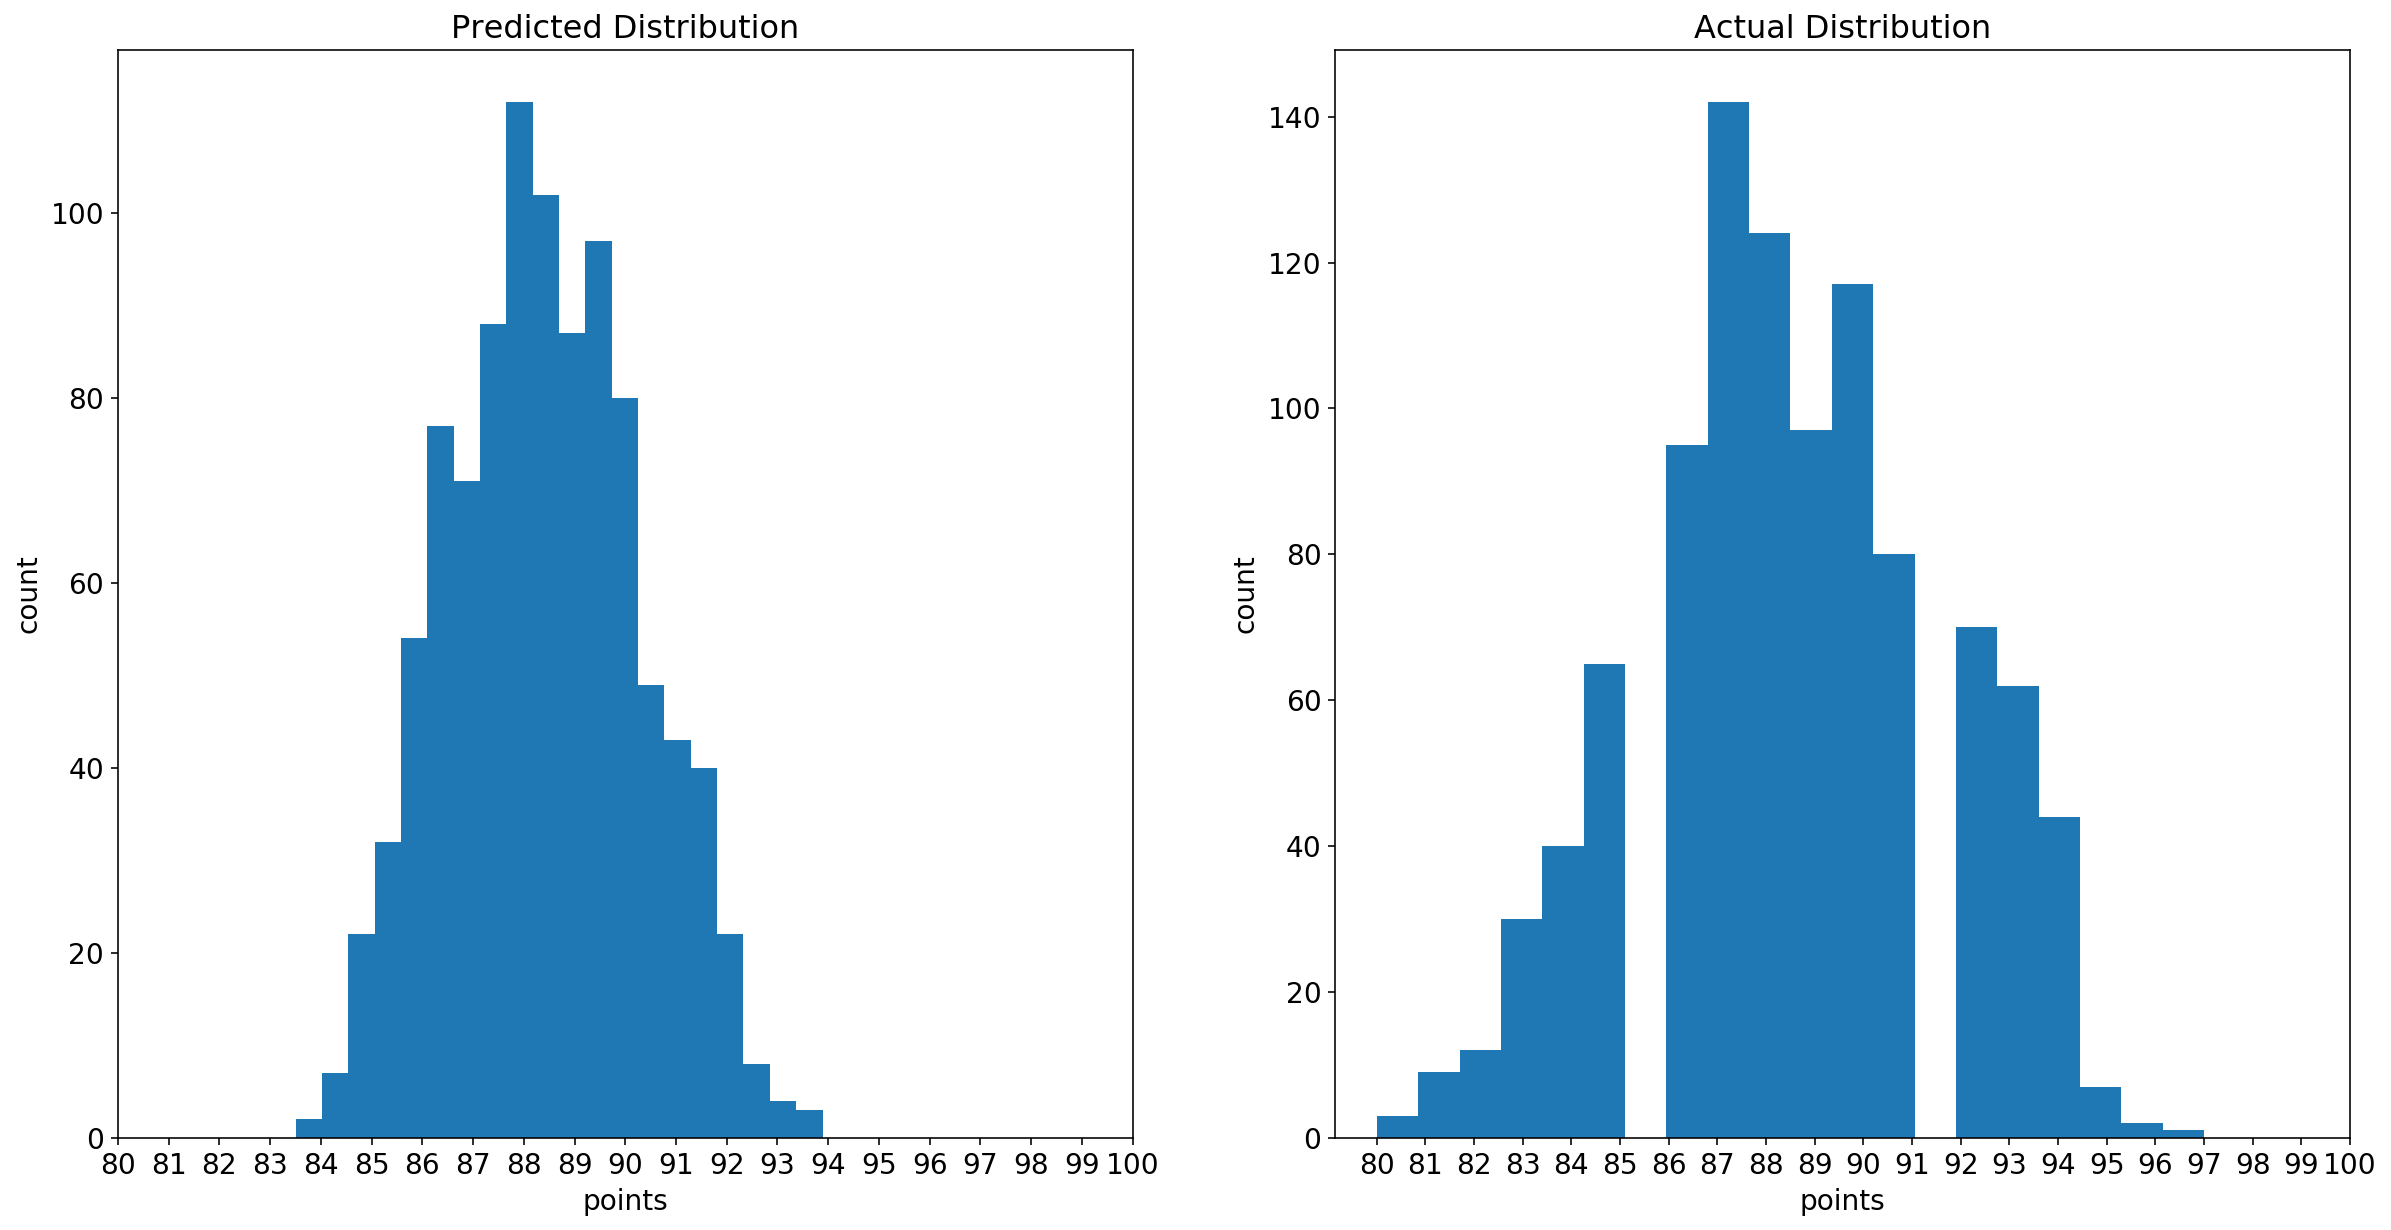

In [14]:
# distribution of the points according to country
figsize(20, 10)
plt.rcParams['font.size'] = 14

# histogram of predictions
ax = plt.subplot(121)
ax.hist(tuned_predictions, 
         bins=20)
ax.set_xlabel("points", size=14)
ax.set_xticks(range(80,101))
ax.set_ylabel("count", size=14)
ax.set_title("Predicted Distribution", size=16)

# histogram of actual values
ax2 = plt.subplot(122)
ax2.hist(convert_target_to_array(test_target), 
         bins=20)
ax2.set_xlabel("points", size=14)
ax2.set_xticks(range(80,101))
ax2.set_ylabel("count", size=14)
ax2.set_title("Actual Distribution", size=16)

Actual distribution was wider. Our model was able to predict points within 83 and 94 and was not able to predict the less-frequent values:
* points below 84
* points above 94

This can be a further improvement area however, we will not touch that part since we showed that good prediction is possible decreasing MSE to 4.93 which is 45% lower than the our common-sense baseline MSE.

## Interpret Feature Importances

In [15]:
# Extract the feature importances into a dataframe
feature_importances = (pd
                       .DataFrame(
                           {'feature': test_features.columns,
                            'importance': random_forests_optimal
                            .feature_importances_}))

feature_importances = (feature_importances
                       .sort_values(by="importance", 
                                    ascending=False))

Text(0.5, 1.0, 'Feature Importances')

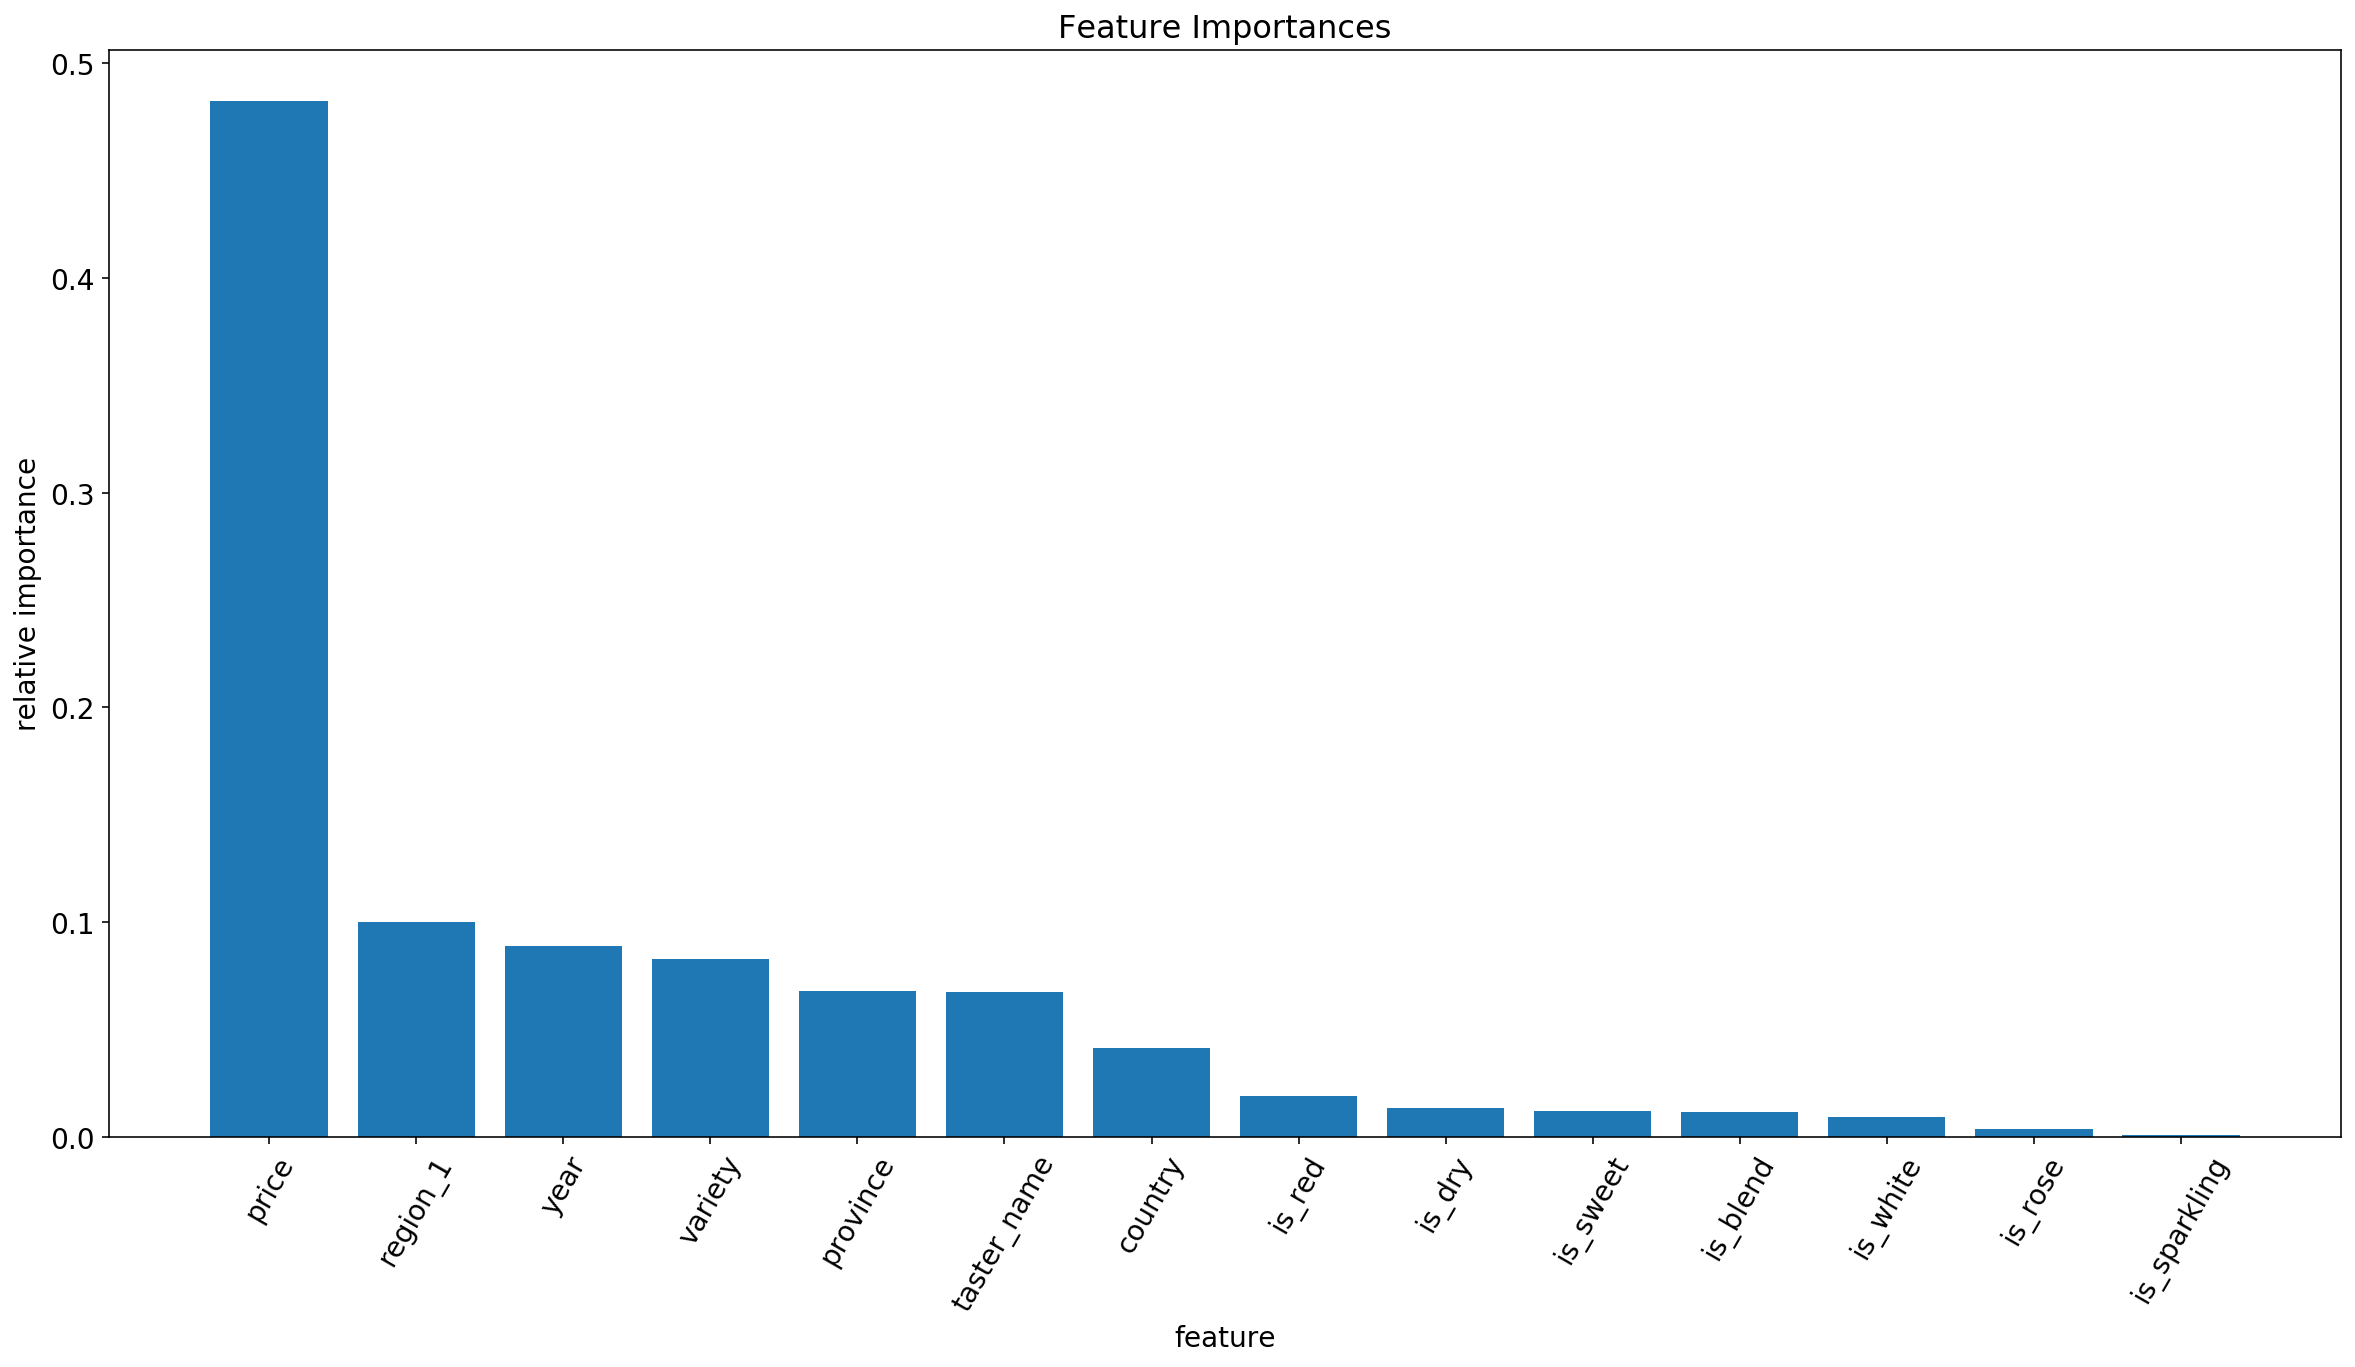

In [16]:
figsize(20, 10)
plt.rcParams['font.size'] = 14

plt.bar(feature_importances["feature"], 
        feature_importances["importance"])

plt.xticks(rotation=60)
plt.xlabel("feature", size=14)
plt.ylabel("relative importance", size=14)
plt.title("Feature Importances", size=16)

According to our model, top 5 features to predict points of a wine:
* price
* region_1
* year 
* variety
* province

This validates our preliminary statement about price being the most important predictor and invalidating the preliminary statement about taster_name.

Moreover, from the extracted features year is the most effective in determining the points a is_sparkling had almost no affect.

## Visualization of a single decision tree

In [17]:
single_tree1 = random_forests_optimal.estimators_[150]

In [18]:
single_tree2 = random_forests_optimal.estimators_[297]

In [19]:
dot_data = StringIO()
tree.export_graphviz(single_tree2,
                     out_file=dot_data,
                     # the target names.
                     # class_names=breast_cancer.target_names,
                     # the feature names.
                     feature_names=list(test_features.columns),
                     filled=True,  # Whether to fill in the boxes with colours.
                     # Whether to round the corners of the boxes.
                     rounded=True,
                     special_characters=True, 
                     max_depth = 3)

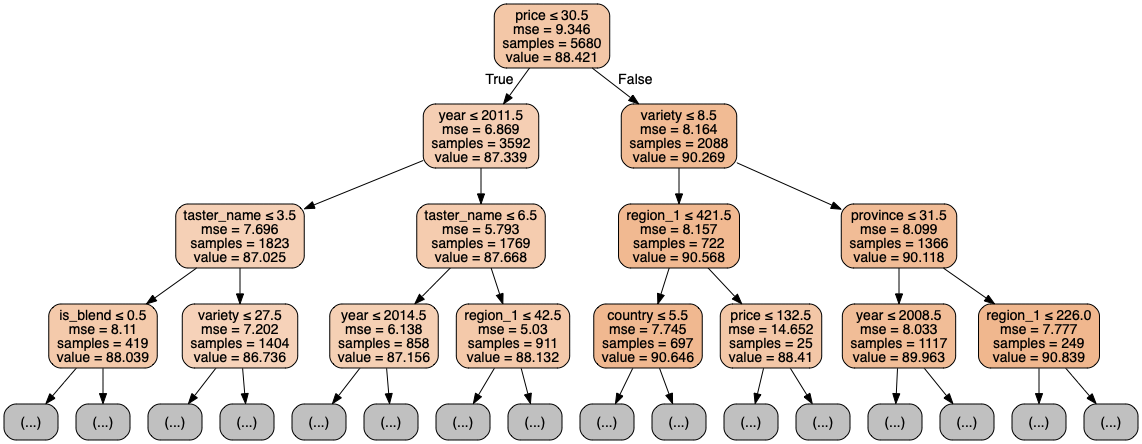

In [20]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())